In [16]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate txt vector files

In [17]:

seed = 6
datasetName = f"x86_64_withVal_withPretrain_ghidra_{seed}"
path = f"/mnt/ssd2t/mandy/Projects/few_shot_fcg/embeddings/{datasetName}/word2vec/testData.pkl"

#### Test for single seed dataset

In [18]:
import pickle
from torch_geometric.data import Batch
from models import GraphSAGE


with open(path, "rb") as f:
    data = pickle.load(f)
    data_list = data[0]
    label = data[1]
# labelDictPath = f"/home/manying/Projects/fcgFewShot/embeddings/x86_64_withVal_withPretrain_ghidra_{seed}/word2vec/labelDict.pkl"
# with open(labelDictPath, "rb") as f:
#     labelDict = pickle.load(f)
# print(f"Seed: {seed}")
# label = label.astype(str)
# for key, value in labelDict.items():
#     label[label == str(value)] = key
    
model = GraphSAGE(dim_in=128, dim_h=128, dim_out=128, num_layers=2, projection = True)


batch = Batch.from_data_list(data_list)
output = model(batch)

/home/mandy/Tools/anaconda3/envs/prototype/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [19]:
import os
output_folder = "./cluster_data"
output_path = os.path.join(output_folder, f"x86_64_withVal_withPretrain_ghidra_{seed}_test.txt")
## empty the file
with open(output_path, "w") as f:
    f.write("")

for outputRow in output:
    with open(output_path, "a") as f:
        f.write('\t'.join([str(x) for x in outputRow.tolist()]) + "\n")



### Distance Builder

In [20]:
import numpy as np

class DistanceBuilder(object):

  """
  Build distance file for cluster
  """  

  def __init__(self):
    self.vectors = []

  def load_points(self, filename):
    '''
    Load all points from file(x dimension vectors)

    Args:
        filename : file's name that contains all points. Format is a vector one line, each dimension value split by blank space
    '''
    with open(filename, 'r') as fp:
      for line in fp:
        self.vectors.append(np.array(list(map(float, line.split('\t')[:])), dtype = np.float32))
    self.vectors = np.array(self.vectors, dtype = np.float32)


  def build_distance_file_for_cluster(self, distance_obj, filename):
    '''
    Save distance and index into file

    Args:
        distance_obj : distance.Distance object for compute the distance of two point
        filename     : file to save the result for cluster
    '''
    fo = open(filename, 'w')
    for i in range(len(self.vectors) - 1):
      for j in range(i, len(self.vectors)):
        fo.write(str(i + 1) + ' ' + str(j + 1) + ' ' + str(distance_obj.distance(self.vectors[i], self.vectors[j])) + '\n')
    fo.close()

In [21]:
from math import sqrt
from abc import ABCMeta, abstractmethod
import numpy as np
import numpy.linalg as linalg


class WrongVecError(Exception):
    '''
    Raised when an operation use empty or not same size vector.
    
    Attributes:
        value: error info
    '''
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        return repr(self.value)

class Distance():
  """
    abstract class, represent distance of two vector
    
    Attributes:
    """    

  __metaclass__ = ABCMeta
         
  @abstractmethod
  def distance(self, vec1, vec2):
    """
    Compute distance of two vector(one line numpy array)
    if you use scipy to store the sparse matrix, please use s.getrow(line_num).toarray() build the one dimensional array
    
    Args:
        vec1: the first line vector, an instance of array
        vec2: the second line vector, an instance of array
      
    Returns:
        the computed distance
    
    Raises:
        TypeError: if vec1 or vec2 is not numpy.ndarray and one line array
    """
    if not isinstance(vec1, np.ndarray) or not isinstance(vec2, np.ndarray):
      raise TypeError("type of vec1 or vec2 is not numpy.ndarray")
    if vec1.ndim is not 1 or vec2.ndim is not 1:
      raise WrongVecError("vec1 or vec2 is not one line array")
    if vec1.size != vec2.size:
      raise WrongVecError("vec1 or vec2 is not same size")    
    pass
  
class SqrtDistance(Distance):
  """
  Square distance
      
  a sub class of Distance
  """  

  def distance(self, vec1, vec2):
    """
    Compute distance of two vector by square distance
    """
    super(SqrtDistance, self).distance(vec1, vec2)      #super method
    vec=vec1-vec2
    return sqrt(sum([pow(item, 2) for item in vec]))

<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_1210168/874899000.py:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if vec1.ndim is not 1 or vec2.ndim is not 1:
/tmp/ipykernel_1210168/874899000.py:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if vec1.ndim is not 1 or vec2.ndim is not 1:


In [22]:
# test for one class
builder = DistanceBuilder()
builder.load_points(f'/home/mandy/Projects/few_shot_fcg/cluster_data/x86_64_withVal_withPretrain_ghidra_6_test.txt')
builder.build_distance_file_for_cluster(SqrtDistance(), f'/home/mandy/Projects/few_shot_fcg/cluster_data/x86_64_withVal_withPretrain_ghidra_6_test.dat')

### Choose Center

In [25]:
import logging
from plot import *
from cluster import *


def plot(data, auto_select_dc = False, datasetName = None):
	logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
	dpcluster = DensityPeakCluster()
	distances, max_dis, min_dis, max_id, rho, rc = dpcluster.local_density(load_paperdata, data, auto_select_dc = auto_select_dc)
	delta, nneigh = min_distance(max_id, max_dis, distances, rho)
	plot_rho_delta(rho, delta, datasetName)   #plot to choose the threthold

2025-02-21 17:30:14,666 : INFO : PROGRESS: load data
2025-02-21 17:30:14,686 : INFO : PROGRESS: load end
2025-02-21 17:30:14,686 : INFO : PROGRESS: select dc
2025-02-21 17:30:14,689 : INFO : PROGRESS: dc - 0.21957410483186204
2025-02-21 17:30:14,689 : INFO : PROGRESS: compute local density
2025-02-21 17:30:14,690 : INFO : PROGRESS: at index #20
2025-02-21 17:30:14,691 : INFO : PROGRESS: at index #40
2025-02-21 17:30:14,692 : INFO : PROGRESS: at index #60
2025-02-21 17:30:14,692 : INFO : PROGRESS: at index #80
2025-02-21 17:30:14,693 : INFO : PROGRESS: at index #100
2025-02-21 17:30:14,693 : INFO : PROGRESS: at index #120
2025-02-21 17:30:14,694 : INFO : PROGRESS: at index #140
2025-02-21 17:30:14,694 : INFO : PROGRESS: at index #160
2025-02-21 17:30:14,695 : INFO : PROGRESS: at index #180
2025-02-21 17:30:14,695 : INFO : PROGRESS: compute min distance to nearest higher density neigh
2025-02-21 17:30:14,695 : INFO : PROGRESS: at index #20
2025-02-21 17:30:14,695 : INFO : PROGRESS: at in

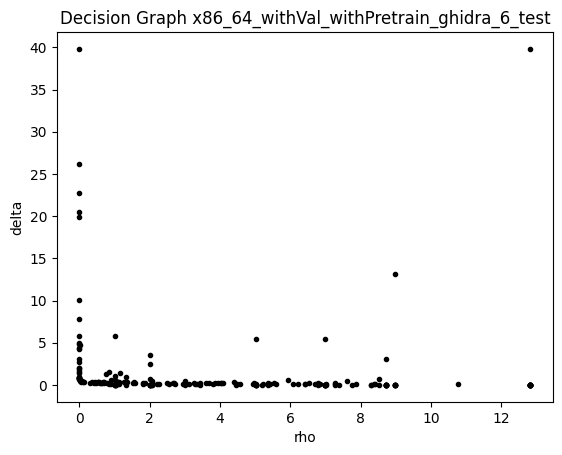

In [26]:
plot(f'./cluster_data/{datasetName}_test.dat', False, datasetName+"_test")

### Cluster

In [30]:
import logging
from plot import *
from cluster import *


def plot(data, density_threshold, distance_threshold, auto_select_dc = False, datasetName = None):
	logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
	dpcluster = DensityPeakCluster()
	rho, delta, nneigh = dpcluster.cluster(load_paperdata, data, density_threshold, distance_threshold, auto_select_dc = auto_select_dc)
	logger.info(str(len(dpcluster.ccenter)) + ' center as below')
	for idx, center in dpcluster.ccenter.items():
		logger.info('%d %f %f' %(idx, rho[center], delta[center]))
	plot_rho_delta(rho, delta, datasetName)   #plot to choose the threthold
	plot_rhodelta_rho(rho,delta, datasetName)  #plot to choose the threthold
	plot_cluster(dpcluster, datasetName)

2025-02-21 17:33:32,401 : INFO : PROGRESS: load data
2025-02-21 17:33:32,422 : INFO : PROGRESS: load end
2025-02-21 17:33:32,422 : INFO : PROGRESS: select dc
2025-02-21 17:33:32,425 : INFO : PROGRESS: dc - 0.21957410483186204
2025-02-21 17:33:32,425 : INFO : PROGRESS: compute local density
2025-02-21 17:33:32,426 : INFO : PROGRESS: at index #20
2025-02-21 17:33:32,428 : INFO : PROGRESS: at index #40
2025-02-21 17:33:32,429 : INFO : PROGRESS: at index #60
2025-02-21 17:33:32,429 : INFO : PROGRESS: at index #80
2025-02-21 17:33:32,430 : INFO : PROGRESS: at index #100
2025-02-21 17:33:32,431 : INFO : PROGRESS: at index #120
2025-02-21 17:33:32,432 : INFO : PROGRESS: at index #140
2025-02-21 17:33:32,432 : INFO : PROGRESS: at index #160
2025-02-21 17:33:32,432 : INFO : PROGRESS: at index #180
2025-02-21 17:33:32,432 : INFO : PROGRESS: compute min distance to nearest higher density neigh
2025-02-21 17:33:32,433 : INFO : PROGRESS: at index #20
2025-02-21 17:33:32,433 : INFO : PROGRESS: at in

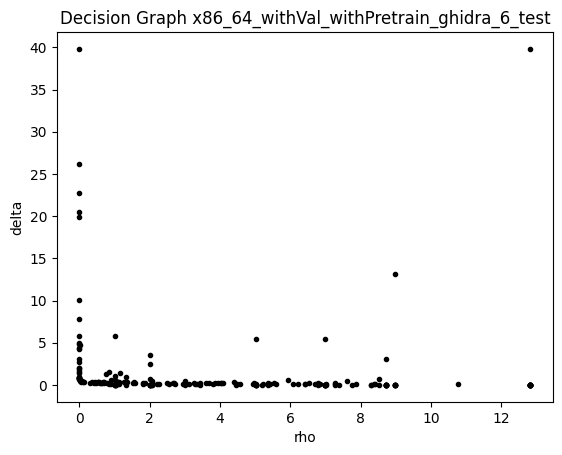

2025-02-21 17:33:32,489 : INFO : PLOT: rho*delta_rho plot


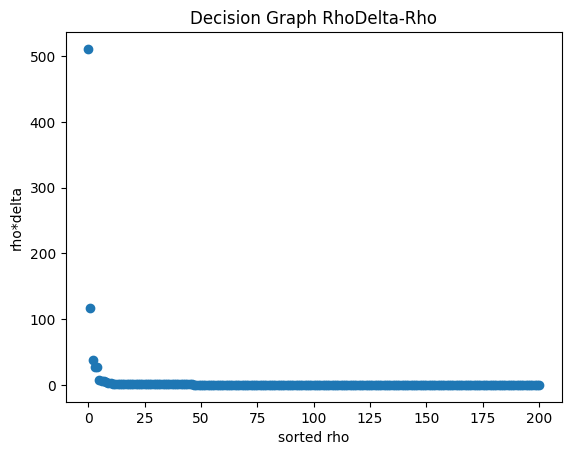

2025-02-21 17:33:32,579 : INFO : PLOT: cluster result, start multi-dimensional scaling
2025-02-21 17:33:32,632 : INFO : PLOT: end mds, start plot


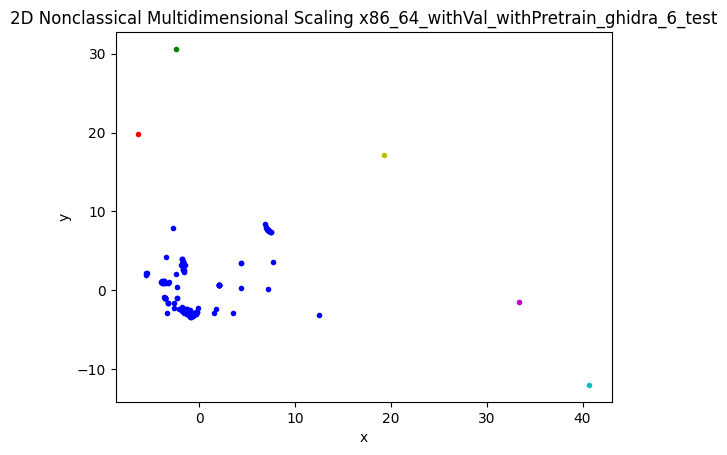

In [ ]:
plot(f'./cluster_data/{datasetName}_test.dat', 4, 0.75, False, datasetName+"_test")